In [ ]:
! nvidia-smi

Sat Apr 17 07:00:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 口罩模型訓練

### 準備資料集

In [ ]:
# 先把數據集上傳至雲端，再到雲端下載回來
! gdown https://drive.google.com/u/1/uc?id=1rf-ggLJ1igZaW7yMbApr2ys0enF0ucJ3

Downloading...
From: https://drive.google.com/u/1/uc?id=1rf-ggLJ1igZaW7yMbApr2ys0enF0ucJ3
To: /content/medical-masks-dataset.zip
151MB [00:01, 78.6MB/s]


In [ ]:
# 解壓縮
! unzip medical-masks-dataset.zip > 1.log

In [ ]:
# 打開一張圖片看看
from PIL import Image
img = Image.open('/content/images/012106.jpg_1140x855.jpg')
img.size

(1140, 855)

In [ ]:
# 為了不佔空間，把圖片縮小成500*400
img.resize((500,400))

In [ ]:
# 打開標記檔案，查看標注資料集
! cat /content/labels/012106.jpg_1140x855.xml

<annotation>
	<folder>images</folder>
	<filename>012106.jpg_1140x855.jpg</filename>
	<path>P:\mask_mouth\images\012106.jpg_1140x855.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1140</width>
		<height>855</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>good</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>654</xmin>
			<ymin>275</ymin>
			<xmax>910</xmax>
			<ymax>517</ymax>
		</bndbox>
	</object>
</annotation>


### Label Image Tool
- https://github.com/tzutalin/labelImg
- https://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html

### 準備YOLO 格式資料

In [ ]:
! rm -rf /content/yolo
! mkdir /content/yolo

In [ ]:
# 取得yolo格式，為了方便以後訓練模型
from bs4 import BeautifulSoup
import os
import shutil

status_dic = {'good': 2, 'bad': 1, 'none': 0}
def getYoloFormat(filename,label_path, img_path, yolo_path, newname):
    with open(label_path+ filename, 'r') as f:
        soup = BeautifulSoup(f.read(), 'xml')
        imgname = soup.select_one('filename').text
        image_w = int(soup.select_one('width').text)
        image_h = int(soup.select_one('height').text)
        ary = []
        for obj in soup.select('object'):
            xmin = int(obj.select_one('xmin').text)
            xmax = int(obj.select_one('xmax').text)
            ymin = int(obj.select_one('ymin').text)
            ymax = int(obj.select_one('ymax').text)
            objclass = status_dic.get(obj.select_one('name').text)

# 轉成yolo格式的關鍵
# 必須將資料轉成以下格式
# 標註圖像之中心點
            x = (xmin + (xmax-xmin)/2) * 1.0 / image_w
            y = (ymin + (ymax-ymin)/2) * 1.0 / image_h
            w = (xmax-xmin) * 1.0 / image_w
            h = (ymax-ymin) * 1.0 / image_h
            
            ary.append(' '.join([str(objclass), str(x),str(y),str(w),str(h)]))
        if os.path.exists(img_path + imgname):
            shutil.copyfile(img_path + imgname, yolo_path + newname + '.jpg')
            with open(yolo_path + newname + '.txt', 'w') as f:
                f.write('\n'.join(ary))

In [ ]:
# 轉換
import os
labelpath = '/content/labels/'
imgpath  = '/content/images/'
yolopath  = '/content/yolo/'
ary = []
for idx, f in enumerate(os.listdir(labelpath)):
    try:
        getYoloFormat(f, labelpath,imgpath, yolopath, str(idx))
# 如有錯誤訊息，會列出      
    except Exception as e:
        print(e)

float division by zero


In [ ]:
# 打開一張圖看看
from PIL import Image
Image.open('/content/yolo/1.jpg')

In [ ]:
# 看圖片標記
# 每個戴口罩的中心點寬高度
! cat /content/yolo/1.txt

2 0.06875 0.3645955451348183 0.04375 0.06565064478311841
2 0.134765625 0.34056271981242675 0.04921875 0.09026963657678781
2 0.26015625 0.3388042203985932 0.0390625 0.07268464243845252
2 0.4578125 0.3417350527549824 0.046875 0.08792497069167643
2 0.408203125 0.3388042203985932 0.02890625 0.05861664712778429
2 0.540625 0.37397420867526376 0.034375 0.05627198124267292
2 0.617578125 0.3669402110199297 0.02109375 0.04220398593200469
2 0.69140625 0.3563892145369285 0.0421875 0.06330597889800703
2 0.78515625 0.3563892145369285 0.034375 0.05861664712778429

### 準備訓練(80)與測試(20)資料集

In [ ]:
! rm -rf /content/cfg_mask
! mkdir /content/cfg_mask

In [ ]:
# 把所有txt檔拿出來，看總共有幾張
import os
datasets = ['/content/yolo/'+ f for f in os.listdir('/content/yolo/') if not f.endswith('.txt')]
len(datasets)

677

In [ ]:
# 訓練張數
len(datasets) * 0.8

541.6

In [ ]:
# 將資料寫入train
with open('/content/cfg_mask/train.txt', 'w') as f:
    f.write('\n'.join(datasets[0:540]))

In [ ]:
# 將資料寫入test
with open('/content/cfg_mask/test.txt', 'w') as f:
    f.write('\n'.join(datasets[540:]))

### 複製參數檔案

In [ ]:
! wget https://github.com/ywchiu/largitdata/raw/master/config/obj.data

In [ ]:
# none:0 -> bad:1 -> good:2
# backup掛載在雲端上
! cat obj.data

classes= 3
train  = /content/cfg_mask/train.txt
valid  = /content/cfg_mask/test.txt
names  = /content/cfg_mask/obj.names
backup = /content/cfg_mask/weights/

In [ ]:
! wget https://github.com/ywchiu/largitdata/raw/master/config/obj.names

In [ ]:
! cat obj.names

none
bad
good


In [ ]:
! mv /content/obj.data /content/cfg_mask/obj.data
! mv /content/obj.names /content/cfg_mask/obj.names

### 建立權重資料夾

In [ ]:
! mkdir /content/cfg_mask/weights

mkdir: cannot create directory ‘/content/cfg_mask/weights’: File exists


In [ ]:
# 載入yolov4.conv.137權重
! cd /content/cfg_mask/weights;  wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

### 修改設定檔參數

In [ ]:
# 可微調yolo架構
! cd darknet/cfg ; cp yolov4-custom.cfg yolo-obj.cfg

In [ ]:
# yolov4與yolov3 調整參數方式不同
! sed -n -e 20p -e 22p -e 970p -e 1058p -e 1146p darknet/cfg/yolo-obj.cfg

max_batches = 500500
steps=400000,450000
classes=80
classes=80
classes=80


參考官方建議
- https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects
- change line max_batches to (classes*2000) => 6000
- change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
- classes => 3

In [ ]:
# 用Linux指令做修改
# 必須根據類別值去做修改
! sed -i "20s/max_batches = 500500/max_batches = 6000/" darknet/cfg/yolo-obj.cfg
! sed -i "22s/steps=400000,450000/steps=4800,5400/" darknet/cfg/yolo-obj.cfg
! sed -i '970s/classes=80/classes=3/' darknet/cfg/yolo-obj.cfg
! sed -i '1058s/classes=80/classes=3/' darknet/cfg/yolo-obj.cfg
! sed -i '1146s/classes=80/classes=3/' darknet/cfg/yolo-obj.cfg

In [ ]:
! sed -n -e 963p -e 1051p -e 1139p darknet/cfg/yolo-obj.cfg

filters=255
filters=255
filters=255


In [ ]:
# filters (classes + 5) * 3
# ( 3 + 5 ) * 3 = 24
# 5: x.y.w.h.c
# 3: 3個尺寸
! sed -i '963s/filters=255/filters=24/' darknet/cfg/yolo-obj.cfg
! sed -i '1051s/filters=255/filters=24/' darknet/cfg/yolo-obj.cfg
! sed -i '1139s/filters=255/filters=24/' darknet/cfg/yolo-obj.cfg

### 效能上考量而修改的參數

In [ ]:
# 以下有4種大小
# high:608, 512, 416, 320 
! sed -i '8s/width=608/width=416/' darknet/cfg/yolo-obj.cfg
! sed -i '9s/height=608/height=416/' darknet/cfg/yolo-obj.cfg

In [ ]:
! sed -i 's/subdivisions=16/subdivisions=12/g' darknet/cfg/yolo-obj.cfg

In [ ]:
! ls -R cfg_mask/

cfg_mask/:
obj.data  obj.names  test.txt  train.txt  weights

cfg_mask/weights:
yolov4.conv.137


### 模型訓練 (7小)

In [ ]:
! cd darknet; ./darknet detector train /content/cfg_mask/obj.data /content/darknet/cfg/yolo-obj.cfg /content/cfg_mask/weights/yolov4.conv.137 -dont_show -map

### 載入既有模型
- https://drive.google.com/file/d/1-3-UpSAnCpEI5LPFwPGER2ylzbg7hGDg/view?usp=sharing

In [ ]:
# 下載權重
! gdown https://drive.google.com/u/1/uc?id=1-3-UpSAnCpEI5LPFwPGER2ylzbg7hGDg

Downloading...
From: https://drive.google.com/u/1/uc?id=1-3-UpSAnCpEI5LPFwPGER2ylzbg7hGDg
To: /content/yolo-obj_best.weights
256MB [00:02, 95.9MB/s]


In [ ]:
# 載一張圖
! wget https://img.youtube.com/vi/eKaX6kJRrtY/0.jpg

--2021-04-17 09:00:11--  https://img.youtube.com/vi/eKaX6kJRrtY/0.jpg
Resolving img.youtube.com (img.youtube.com)... 74.125.20.100, 74.125.20.139, 74.125.20.138, ...
Connecting to img.youtube.com (img.youtube.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24667 (24K) [image/jpeg]
Saving to: ‘0.jpg’

0.jpg               100%[===================>]  24.09K  --.-KB/s    in 0s      

2021-04-17 09:00:11 (97.9 MB/s) - ‘0.jpg’ saved [24667/24667]



In [ ]:
! cat /content/cfg_mask/obj.names > /content/darknet/data/coco.names

In [ ]:
# 預測
! cd darknet; ./darknet detect /content/darknet/cfg/yolo-obj.cfg  /content/yolo-obj_best.weights /content/0.jpg

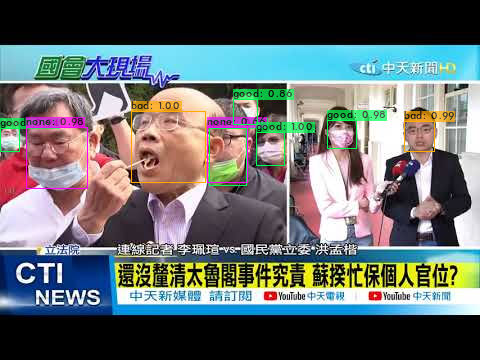

In [ ]:
# 打開預測後影像
Image.open('/content/darknet/predictions.jpg')

### if 1000個run不夠，繼續訓練模型

In [ ]:
! cd darknet; ./darknet detector train /content/cfg_mask/obj.data /content/darknet/cfg/yolo-obj.cfg /content/yolo-obj_best.weights -dont_show -map

### 評估模型

In [ ]:
# 準確率
# none:80.09%
# bad:91.23%
# good:96.73%
# F1-score:0.91
! cd darknet; ./darknet detector map /content/cfg_mask/obj.data /content/darknet/cfg/yolo-obj.cfg /content/yolo-obj_best.weights

In [ ]:
! cat cfg_mask/obj.data

classes= 3
train  = /content/cfg_mask/train.txt
valid  = /content/cfg_mask/test.txt
names  = /content/cfg_mask/obj.names
backup = /content/cfg_mask/weights/

In [ ]:
# 訓練完後模型自動存到雲端
#backup = /content/drive/MyDrive/tibamedl/

## 連結opencv
- https://www.youtube.com/watch?v=T_zFMRFCFfk&t=19s
- https://github.com/ywchiu/largitdata/blob/master/code/Course_128.ipynb

In [ ]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 136kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("/content/darknet/cfg/yolo-obj.cfg","/content/yolo-obj_best.weights")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("/content/cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

def yolo_detect(frame):
    # forward propogation
    img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape 
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # get detection boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.3:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y -5), font, 3, color, 3)
    return img

In [ ]:
img = cv2.imread("/Users/davidchiu/Desktop/test.jpg")
im = yolo_detect(img)
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)